In [1]:
import pandas as pd
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', None)

from google.cloud import bigquery

In [2]:
client = bigquery.Client()

query="""
SELECT * FROM goldenfleece.sentiment.gkg_nov_2020_sample 
"""
df = client.query(query).to_dataframe()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507819 entries, 0 to 507818
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   GKGRECORDID                 507819 non-null  object
 1   DATE                        507819 non-null  object
 2   V2Themes                    507819 non-null  object
 3   TONE                        507819 non-null  object
 4   POSITIVE_SCORE              507819 non-null  object
 5   NEGATIVE_SCORE              507819 non-null  object
 6   POLARITY                    507819 non-null  object
 7   ACTIVITY_REFERENCE_DENSITY  507819 non-null  object
 8   SELF_REFERENCE_DENSITY      507819 non-null  object
 9   WORD_COUNT                  507819 non-null  object
dtypes: object(10)
memory usage: 38.7+ MB


### Pre-process themes

We will first pre-process the V2Themes column. 

Normally, as part of preprocessing, we will:
1. Tokenize
2. Lemmatize the tokens
3. Compute bigrams
4. Compute a bag-of-words representation of the data

However, we can skip step 2 and 3 here because the V2Themes column already contains proper words/themes. After tokenizing, we can directly transform the documents to a vectorized form. 

In [4]:
def pre_process_themes(df):
    # drop missing themes rows
    df = df.dropna(subset=["V2Themes"])
    # split by ';' and remove everything after ',' 
    df["V2Themes"] = [[re.sub(r',.*', '', theme) for theme in doc.split(';') if theme] for doc in df["V2Themes"].tolist()]
    return df

pre_processed_df = pre_process_themes(df)

In [6]:
from gensim.corpora import Dictionary

# get the processed corpus
processed_corpus = pre_processed_df["V2Themes"].tolist()

# create a dictionary representation of the documents
dictionary = Dictionary(processed_corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(processed_corpus))

Number of unique tokens: 13376
Number of documents: 507819


In [7]:
dictionary.save("dictionary")

In [6]:
# bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_corpus]

# sense check first and fifth corpus
print(f'Bag-of-words representation of the first document: {bow_corpus[0]}')
print(f'Bag-of-words representation of the fifth document: {bow_corpus[4]}')

Bag-of-words representation of the first document: [(0, 1)]
Bag-of-words representation of the fifth document: [(57, 1), (61, 1), (62, 1)]


In [7]:
# Train LDA model.
from gensim.models import LdaModel, LdaMulticore

# Set training parameters.
num_topics = 8
passes = 1 # default is 1
iterations = 400 # default is 50
eval_every = 1  # to monitor convergence but set to None in production because it takes too much time 
chunksize = 2000 # increasing this will speed up training, as long as the chunk of documents can fit into memory

model = LdaMulticore(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=num_topics,
    workers=3,
    alpha='symmetric', # 'auto' is only available in plain LDA model
    eta='auto',
#     iterations=iterations,
#     passes=passes,
#     eval_every=eval_every
)

In [31]:
model.save("lda_model")

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Compute topic coherence score

Coherence measures the relative distance between words within a topic. 

There are two major types:
- 'u_mass': -14 < x < 14 (default, uses bow_corpus)
- 'c_v': 0 < x < 1 (slower, uses processed_corpus)

[Stack Overflow](#https://stackoverflow.com/questions/54762690/coherence-score-0-4-is-good-or-bad)

Alternative way: 
[Gensim Coherence Model](#https://radimrehurek.com/gensim/models/coherencemodel.html)

In [8]:
# Each element in the list is a pair of a topic representation and its coherence score. 
# Topic representations are distributions of words, represented as a list of pairs of word IDs and their probabilities.

top_topics = model.top_topics(texts=processed_corpus, coherence="c_v")

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: 0.6228.


### Word Clouds of Top N Keywords in Each Topic

In [9]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

In [10]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=2500,
                  max_words=10,
                  min_font_size=7,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

In [11]:
# Each element in the list is a topic, each represented either as a string (when formatted == True) or a 2-tuple of (word, probability)
topics = model.show_topics(formatted=False)

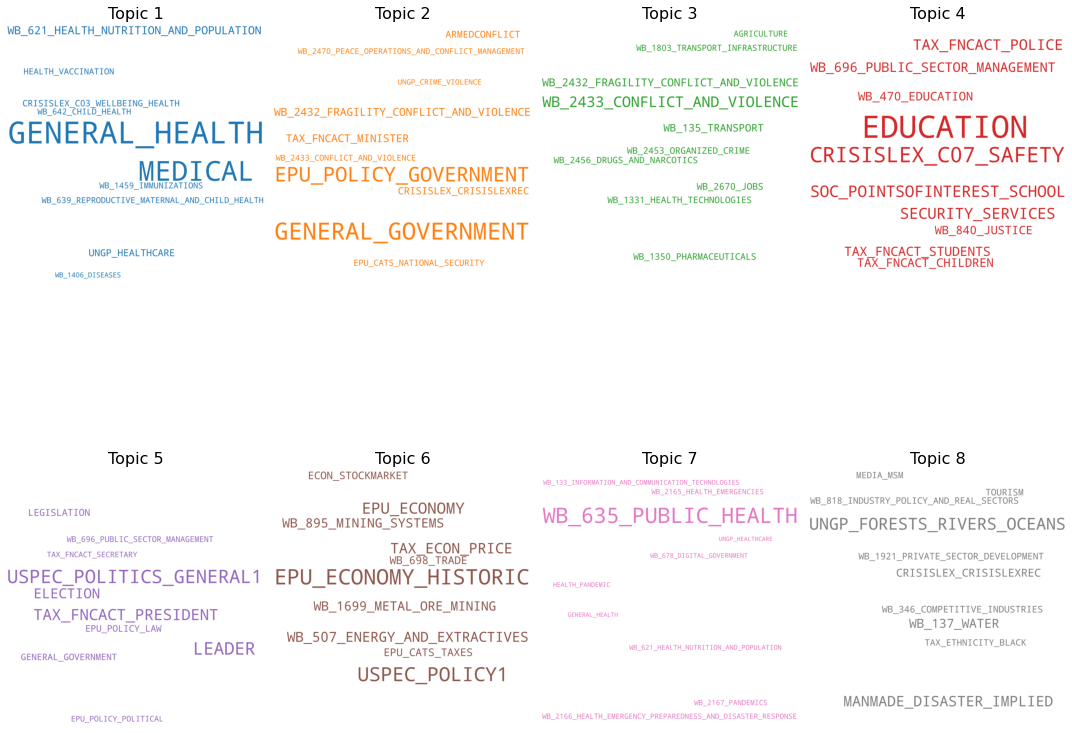

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    # create dict of {word:freq}
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    ax.axis('off')

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
plt.margins(x=0, y=0)

In [33]:
fig.savefig('wordcloud.png')

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, bow_corpus, dictionary=model.id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.302357  0.082040       1        1  17.140628
1      0.131586  0.116514       2        1  13.017318
2     -0.013504 -0.041605       3        1   7.253660
3      0.072986  0.192825       4        1  13.316019
4      0.211085  0.032548       5        1  13.666454
5      0.083386 -0.327093       6        1  10.317497
6     -0.181795 -0.084068       7        1  14.439728
7     -0.001387  0.028840       8        1  10.848696, topic_info=                                     Term           Freq          Total Category  logprob  loglift
135                        GENERAL_HEALTH  536040.000000  536040.000000  Default  30.0000  30.0000
62                USPEC_POLITICS_GENERAL1  351862.000000  351862.000000  Default  29.0000  29.0000
137                               MEDICAL  375298.000000  375298.000000  Default  28.0000  28.0000
57                                 LEADER  320099.000000  320099.000000  Default  27.0000  27.0000
61                   TAX_FNCACT_PRESIDENT  214692.000000  214692.000000  Default  26.0000  26.0000
..                                    ...            ...            ...      ...      ...      ...
70                       WB_135_TRANSPORT   23542.912834   95070.636581   Topic8  -4.6694   0.8253
370  WB_435_AGRICULTURE_AND_FOOD_SECURITY   19787.716189   57524.401860   Topic8  -4.8431   1.1540
203                                AFFECT   20384.111070   77423.230218   Topic8  -4.8134   0.8866
305             WB_1466_SOCIAL_ASSISTANCE   16092.604889   30143.760548   Topic8  -5.0498   1.5935
264                               SCIENCE   17002.790478   92354.389460   Topic8  -4.9948   0.5289

[677 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
203       1  0.215698           AFFECT
203       2  0.205856           AFFECT
203       3  0.036733           AFFECT
203       4  0.084768           AFFECT
203       5  0.047725           AFFECT
...     ...       ...              ...
1358      1  0.000517  WB_990_DRAINAGE
1358      2  0.003102  WB_990_DRAINAGE
1358      4  0.000517  WB_990_DRAINAGE
1358      5  0.001551  WB_990_DRAINAGE
1358      8  0.993572  WB_990_DRAINAGE

[2664 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [44]:
print(pyLDAvis.gensim.prepare.__doc__)

Transforms the Gensim TopicModel and related corpus and dictionary into
    the data structures needed for the visualization.

    Parameters
    ----------
    topic_model : gensim.models.ldamodel.LdaModel
        An already trained Gensim LdaModel. The other gensim model types are
        not supported (PRs welcome).

    corpus : array-like list of bag of word docs in tuple form or scipy CSC matrix
        The corpus in bag of word form, the same docs used to train the model.
        The corpus is transformed into a csc matrix internally, if you intend to
        call prepare multiple times it is a good idea to first call
        `gensim.matutils.corpus2csc(corpus)` and pass in the csc matrix instead.

    For example: [(50, 3), (63, 5), ....]

    dictionary: gensim.corpora.Dictionary
        The dictionary object used to create the corpus. Needed to extract the
        actual terms (not ids).

    doc_topic_dist (optional): Document topic distribution from LDA (default=None)
     

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
from pyLDAvis import save_html

save_html(vis, "lda_vis.html")

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
result = {}
for i, row in enumerate(model[bow_corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    dominant_topic = row[0][0]
    result[i] = dominant_topic + 1

topic = pd.Series(result, name="topic")    
topic_df = df.merge(topic, left_index=True, right_index=True)
assert len(topic) == len(topic_df)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
topic_df.info(memory_usage="deep")
topic_df["DATE"] = pd.to_datetime(topic_df["DATE"])
topic_df.to_csv("../data/gkg_nov_2020_sample_topic.csv", index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507819 entries, 0 to 507818
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   GKGRECORDID                 507819 non-null  object
 1   DATE                        507819 non-null  object
 2   V2Themes                    507819 non-null  object
 3   TONE                        507819 non-null  object
 4   POSITIVE_SCORE              507819 non-null  object
 5   NEGATIVE_SCORE              507819 non-null  object
 6   POLARITY                    507819 non-null  object
 7   ACTIVITY_REFERENCE_DENSITY  507819 non-null  object
 8   SELF_REFERENCE_DENSITY      507819 non-null  object
 9   WORD_COUNT                  507819 non-null  object
 10  topic                       507819 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1.0 GB
